In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
import numpy as np
import pandas as pd
import calpred
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

# Simulate traits
Binary traits are converted from quantative traits with 20% prevalence.

In [2]:
np.random.seed(1234)
data = calpred.simulate_toy_quant_data(n=1000)
data["y_binary"] = (data["y"] > np.quantile(data["y"], q=0.8)).astype(int)

# Fit quantative traits

In [3]:
model_fit = calpred.fit(
    y=data["y"],
    x=data[["yhat", "ancestry", "age", "sex"]],
    z=data[["yhat", "ancestry", "age", "sex"]],
)
y_mean, y_sd = calpred.predict(
    x=data[["yhat", "ancestry", "age", "sex"]],
    z=data[["yhat", "ancestry", "age", "sex"]],
    model_fit=model_fit,
)
model_fit

CalPredFit(
----------------------------------------
Estimates for the mean:
              coef        se    z-score
const     0.064887  0.048774   1.330352
yhat      0.995516  0.047859  20.801204
ancestry  0.036226  0.047275   0.766287
age      -0.041622  0.046817  -0.889039
sex       0.104111  0.047030   2.213694
------
Estimates for the sd:
              coef        se    z-score
const     0.821662  0.044840  18.324490
yhat     -0.010084  0.046251  -0.218028
ancestry  0.244023  0.044979   5.425290
age      -0.133294  0.045032  -2.959961
sex       0.140260  0.044960   3.119630
----------------------------------------
)

In [4]:
model_fit = calpred.fit_binary(
    y=data["y_binary"],
    x=data[["yhat", "ancestry", "age", "sex"]],
    z=data[["ancestry", "age", "sex"]],
)

y_prob, y_mean, y_sd = calpred.predict_binary(
    x=data[["yhat", "ancestry", "age", "sex"]],
    z=data[["ancestry", "age", "sex"]],
    model_fit=model_fit,
)

model_fit

------------------------------------------------------------------
Maximum Likelihood estimation of Heteroskedastic Binary model 
Newton-Raphson maximisation, 5 iterations
Return code 1: gradient close to zero (gradtol)
Log-Likelihood: -397.5223 
8  free parameters

Estimates for the mean:
            Estimate Std. error  z value Pr(> z)    
mean_matV1 -1.093307   0.062562 -17.4755  <2e-16 ***
mean_matV2  0.726246   0.068005  10.6794  <2e-16 ***
mean_matV3 -0.150104   0.092037  -1.6309  0.1029    
mean_matV4 -0.094977   0.071462  -1.3290  0.1838    
mean_matV5  0.013307   0.074599   0.1784  0.8584    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Estimates for lnsigma:
              Estimate Std. error z value Pr(> z)    
het.sd_matV1  0.355679   0.095639  3.7190  0.0002 ***
het.sd_matV2 -0.004330   0.072908 -0.0594  0.9526    
het.sd_matV3  0.112353   0.081877  1.3722  0.1700    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

LR test of lnsig

CalPredFit(
----------------------------------------
Estimates for the mean:
              coef        se    z-score
const    -1.093307  0.062562 -17.475501
yhat      0.726246  0.068005  10.679364
ancestry -0.150104  0.092037  -1.630913
age      -0.094977  0.071462  -1.329047
sex       0.013307  0.074599   0.178376
------
Estimates for the sd:
              coef        se   z-score
ancestry  0.711357  0.191279  3.718954
age      -0.008660  0.145816 -0.059389
sex       0.224707  0.163754  1.372225
----------------------------------------
)

In [5]:
exog = sm.add_constant(data[["yhat", "ancestry", "age", "sex"]])
probit_model = sm.Probit(
    endog=data["y_binary"],
    exog=sm.add_constant(data[["yhat", "ancestry", "age", "sex"]]),
).fit(disp=0)
y_prob2 = probit_model.predict(exog)

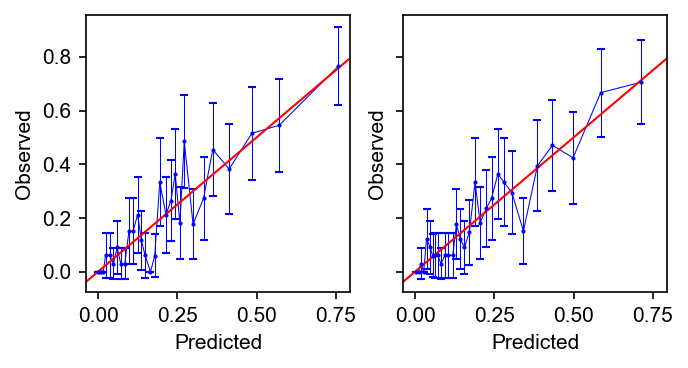

In [6]:
fig, axes = plt.subplots(figsize=(5, 2.4), dpi=150, ncols=2, sharex=True, sharey=True)
calpred.plot_prob_calibration(prob=y_prob, y=data["y_binary"], ax=axes[0])
calpred.plot_prob_calibration(prob=y_prob2, y=data["y_binary"], ax=axes[1])

(0.0, 1.0)

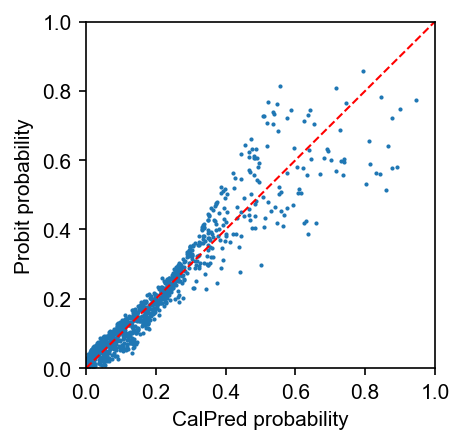

In [7]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(y_prob, y_prob2, s=1)
ax.set_xlabel("CalPred probability")
ax.set_ylabel("Probit probability")
ax.axline((0, 0), slope=1, ls="--", color="red", lw=1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# TODO: plot AUC for CalPred and Probit